# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import pickle
from sklearn.utils import shuffle
import random
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
import tensorflow as tf 
from sklearn.metrics import confusion_matrix, classification_report
import os 
from PIL import Image
# Visualizations will be shown in the notebook.
%matplotlib inline 

# TODO: Fill this in based on where you saved the training and testing data

# Load pickled data
training_file = "../traffic-signs-data/train.p"
validation_file= "../traffic-signs-data/valid.p"
testing_file = "../traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
# training set, validation set and test set
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# shuffle the trainiing data
X_train, y_train = shuffle(X_train, y_train, random_state = 123)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_test.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(list(y_train) + list(y_valid) + list(y_test)))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Shape of image data =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Shape of image data = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.

# read csv file containing the dictionary between classes and names of traffic signs
df_names = pd.read_csv('signnames.csv')

# compute the frequency for each class in each dataset (training, validation, test)
# and then store the list of the frequencies into the new column 'Count_...' 
# (... = train, valid, test) of df_names

def frequency_data(labels):
    freq_list = []
    count_dict = Counter(labels)
    for i in range(n_classes):
        freq_list.append(count_dict[i])
    return freq_list

# count of classes
df_names['Count_train'] = frequency_data(y_train)
df_names['Count_valid'] = frequency_data(y_valid)
df_names['Count_test'] = frequency_data(y_test)

# percentage of classes
df_names['Percent_train'] = df_names['Count_train'].astype('float')/n_train
df_names['Percent_valid'] = df_names['Count_valid'].astype('float')/n_validation
df_names['Percent_test'] = df_names['Count_test'].astype('float')/n_test

# sort by the frequency in the training data set (descendng order)
df_names = df_names.sort_values('Count_train', ascending= False)

# we also create dictionary for class id and traffic sign name for later purpose
name_dict = dict(zip(df_names['ClassId'], df_names['SignName']))

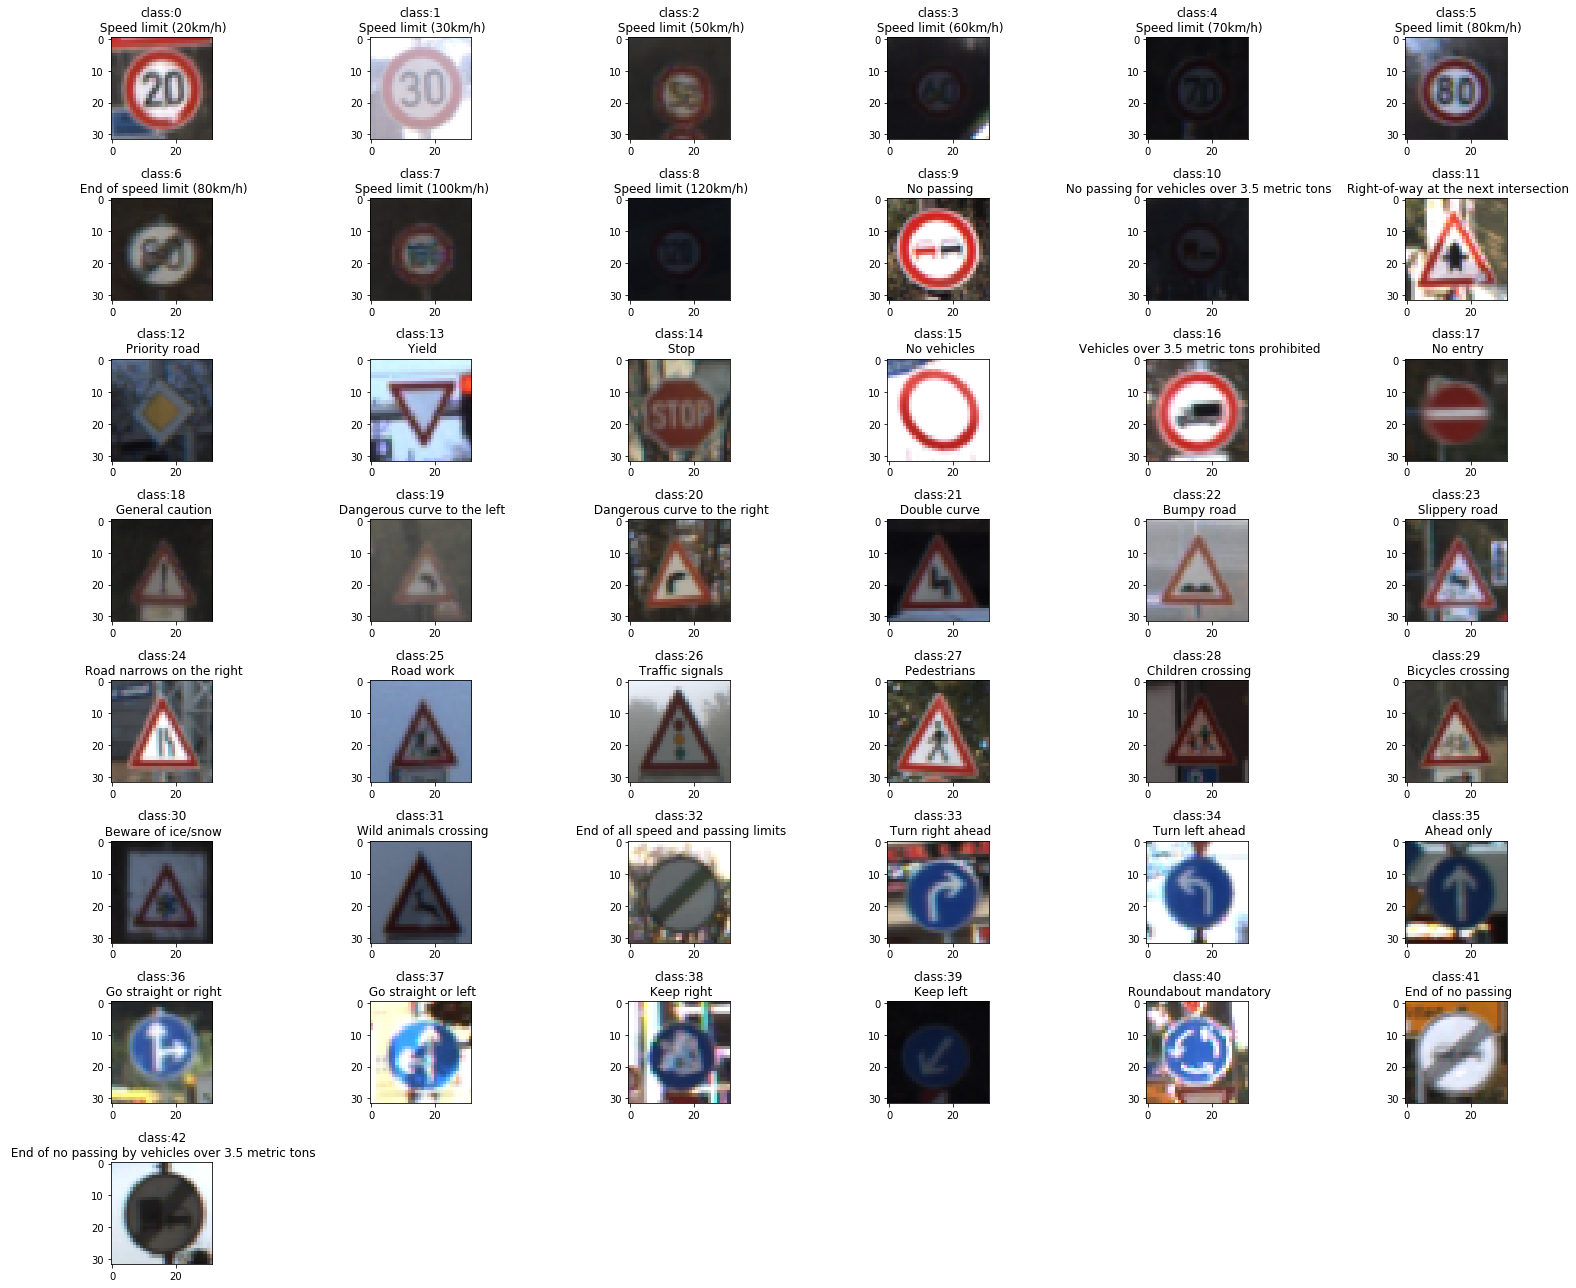

In [13]:
### In this part we plot one example from each class 
### In case some sample images are too dark, run this cell one more time. 

# randomly sample from each class
random.seed(19)
list_index_samples = []
for _class in range(n_classes):
    list_each_class = [i for i, label in enumerate(y_train) if label == _class]
    list_index_samples.append(np.random.choice(list_each_class))    
    
# plot the samples 
fig=plt.figure(figsize=(22, 18))
columns = 6
rows = math.ceil(n_classes/columns)
for i in range(1,n_classes+1):
    ind = list_index_samples[i-1]
    fig.add_subplot(rows, columns, i)
    plt.title('class:' + str(i-1) + '\n ' + name_dict[i-1])
    plt.imshow(X_train[ind])
fig.tight_layout()
plt.savefig('examples_sign.png')
plt.show()

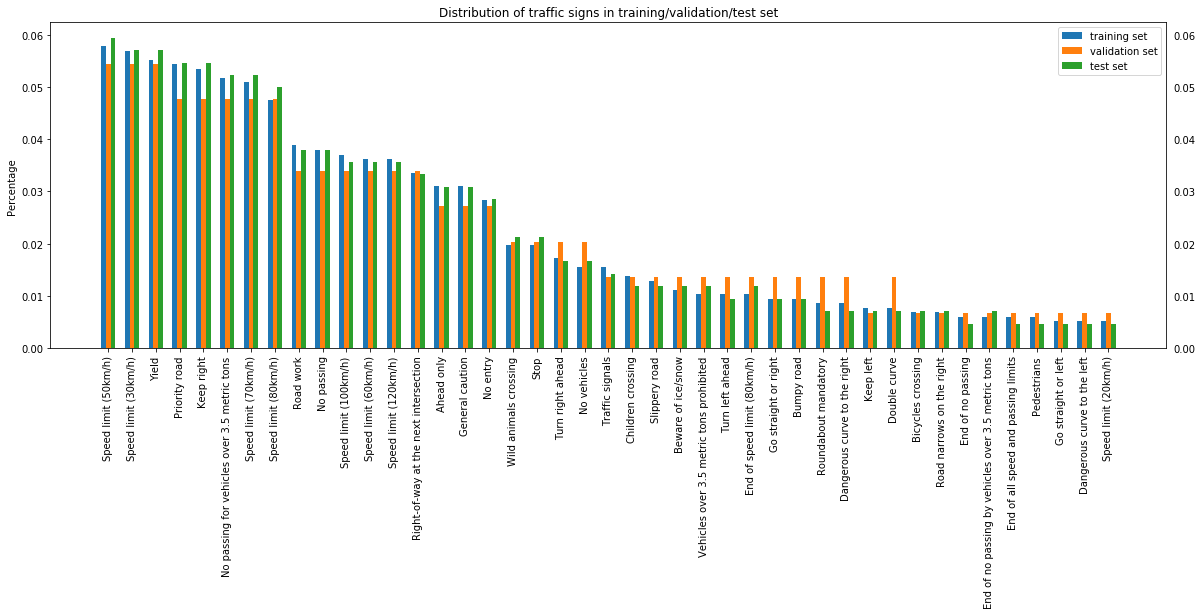

In [14]:
### In this part, we will see the distribution of the classes in each data set. 

# plot for data 
plt.figure(figsize=(20,6))
w = 1.0
step_aes = 5.0
plt.bar(np.arange(n_classes*step_aes,step=step_aes)-w, list(df_names['Percent_train']), w, align='center')
plt.bar(np.arange(n_classes*step_aes,step=step_aes), list(df_names['Percent_valid']), w, align='center')
plt.bar(np.arange(n_classes*step_aes,step=step_aes)+w, list(df_names['Percent_test']), w, align='center')
plt.xticks(np.arange(n_classes*step_aes,step=step_aes), list(df_names['SignName']), rotation=90)
plt.tick_params(axis='y', which='both', labelleft='on', labelright='on')
plt.title('Distribution of traffic signs in training/validation/test set')
plt.ylabel('Percentage')
plt.legend(['training set','validation set','test set'])
plt.savefig('distribution_data.png', bbox_inches = 'tight')
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [15]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

# copy the dataset before preprocessing 
X_train_after = X_train.copy()
X_valid_after = X_valid.copy()
X_test_after = X_test.copy()

y_train_after = y_train.copy()
y_valid_after = y_valid.copy()
y_test_after = y_test.copy()

In [18]:
### In this part, we define some functions to be used for data argumentation

# translation (dev_x/dev_y are maximum absolute translation distance in x/y direction)
def translation(image, dev_x, dev_y):
    
    dx = np.random.choice(range(-dev_x, dev_x))
    dy = np.random.choice(range(-dev_y, dev_y))
    M =  np.float32([[1,0, dx],[0, 1, dy]]) # transformation matrix 
    
    return cv2.warpAffine(src=image, M=M, dsize = image.shape[:2])

# rotation (input "angle" is the maximum absolute value of the rotation angle by this function)
def rotation(image, angle):
    
    dtheta = np.random.choice(range(-angle, angle))
    center = (math.floor(image.shape[0]/2), math.floor(image.shape[1]/2))
    M = cv2.getRotationMatrix2D(center, dtheta, scale=1) # transformation matrix 
    
    return cv2.warpAffine(src=image, M=M, dsize = image.shape[:2])


# scaling (an image is scaled with a rate between input "scale" and 1 
# (or, 1 and "scale" if "scale" is larger than 1))
def scaling(image, scale):
    if(scale >= 1.0):
        high = scale 
        low = 1.0
    else:
        high = 1.0
        low = scale
    sc = np.random.uniform(low, high)
    center = (math.floor(image.shape[0]/2), math.floor(image.shape[1]/2))
    M = cv2.getRotationMatrix2D(center, 0, scale=sc)
    
    return cv2.warpAffine(src=image, M=M, dsize = image.shape[:2])


# this function applies a series of the data argumentation to the input images  
def data_argumentation(X_data, y_data, count):
    indices = np.random.choice(len(X_data), count)
    X_argumented_images = []
    y_argumented_images = []
    list_indices = []
    for idx in indices: 
        y_argumented_images.append(y_data[idx])
        
        X_argumented = X_data[idx].copy()
        X_argumented = translation(X_argumented, 4, 4)
        X_argumented = rotation(X_argumented, 15)
        sign = np.random.choice([-1.0,1.0],1)
        X_argumented = scaling(X_argumented, 1.0 + sign*0.05)
        
        X_argumented_images.append(X_argumented)
        
        list_indices.append(idx)
        
    return np.array(X_argumented_images), np.array(y_argumented_images), list_indices

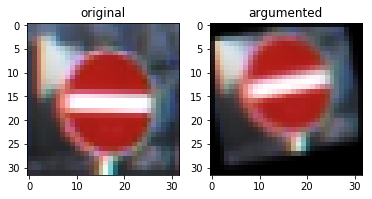

In [23]:
# example of the argumentation
random.seed(24)

argemented_example = data_argumentation(X_train, y_train, 10)

fig=plt.figure(figsize=(6, 3))
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(X_train[argemented_example[2][2]])
plt.title('original')
fig.add_subplot(rows, columns, 2)
plt.title('argumented')
plt.imshow(argemented_example[0][2])
plt.savefig('argumentation.png')
plt.show()

In [24]:
### functions for converting the images to grayscale 

def color_to_gray(color_img):
    gray_img = (color_img[:,:,0].astype(float) + color_img[:,:,1].astype(float) + color_img[:,:,2].astype(float))/3.0
      
    gray_img = gray_img.reshape((gray_img.shape[0],gray_img.shape[1], 1))
    
    return gray_img

def color_to_gray_data(dataset):
    
    gray_dataset = list(map(color_to_gray, dataset))
    gray_dataset = np.asarray(gray_dataset)
    
    return gray_dataset

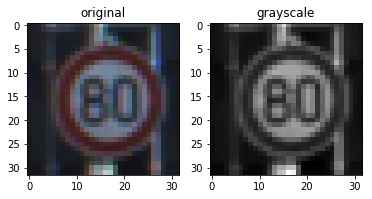

In [25]:
# example of the conversion to grayscale
random.seed(21)

# pick an example
index = random.randint(0, len(X_train))
image = X_train_after[index]
gray_image = color_to_gray(image)
gray_image = gray_image.squeeze() # convert to 2d array for plot

# plot the samples 
fig=plt.figure(figsize=(6, 3))
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(image)
plt.title('original')
fig.add_subplot(rows, columns, 2)
plt.imshow(gray_image.squeeze(), cmap = 'gray')
plt.title('grayscale')
plt.savefig('color_to_gray.png')
plt.show()

In [26]:
### normalize the image data
def image_normalization(dataset):
    return (dataset - 128.0)/128.0

### this gives the pipline for the preprocessing (except for the data argumentation)
def image_preprocessing(dataset, grayscale = True, normalize = True): 
    processed = dataset.copy()
    if grayscale:
        processed = color_to_gray_data(processed)
    if normalize:
        processed = image_normalization(processed)

    return processed 

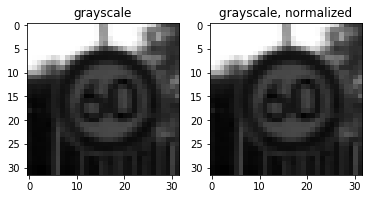

In [27]:
# example of images before and after the normalization 
# (normalization is applied to a grayscale image)

# pick an example and convert to grayscale
index = random.randint(0, len(X_train))
image = X_train_after[index]
gray_image = color_to_gray(image)
# data normalization 
gray_image_normalized = image_normalization(gray_image)
gray_image_normalized = gray_image_normalized.squeeze() # convert to 2d array for plot

# plot the samples 
fig=plt.figure(figsize=(6, 3))
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(gray_image.squeeze(),cmap = 'gray')
plt.title('grayscale')
fig.add_subplot(rows, columns, 2)
plt.imshow(gray_image_normalized.squeeze(), cmap = 'gray')
plt.title('grayscale, normalized')
plt.savefig('normalization.png')
plt.show()

In [28]:
# ### In case one does not want to set the number of images in each class to be the same, 
# ### Use the next three cells and comment out all the cells below these three cells

# ### Here we add the argumented data to the training set (20% of the original training set)
# X_train_arged , y_train_arged, _ = data_argumentation(X_train_after, y_train_after, count = math.floor(n_train*0.2))
# X_train_after = np.concatenate((X_train_after, X_train_arged), axis = 0)
# y_train_after = np.concatenate((y_train_after, y_train_arged), axis = 0)

# # shuffling the training data
# X_train_after, y_train_after = shuffle(X_train_after, y_train_after, random_state = 135)

# ### Here we will carry out the image processing to the training, validation and test datasets
# grayscale = True
# X_train_after = image_preprocessing(X_train_after, grayscale = grayscale)
# X_valid_after = image_preprocessing(X_valid_after, grayscale = grayscale)
# X_test_after = image_preprocessing(X_test_after, grayscale = grayscale)

# # now we update the number of the channel 
# # number of channel of image
# n_channel = X_train_after.shape[3]

In [29]:
# # size of the training dataset and shape of an image after the data preprocessing
# print("Number of training examples after data preprocessing =", X_train_after.shape[0])
# print("Shape of image data =", X_train_after.shape[1:])

In [30]:
# # examples of the preprocessed images
# list_index_samples = random.sample(range(len(X_train)), 10)
# fig=plt.figure(figsize=(15, 3))
# columns = 5
# rows = 2
# for i in range(1,len(list_index_samples)+1):
#     ind = list_index_samples[i-1]
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(X_train_after[ind].squeeze(), cmap ='gray')
# fig.tight_layout()
# plt.savefig('preprocessed.png')
# plt.show()

In [31]:
### use the undersampling and image synthesis with data argumentation 
### so that the number of the samples in each class becomes the same. 

# this function does the following two things:
# 1) if the number of samples in a given class is larger than count (= number of samples in the final dataset), 
#     then do undersampling 
# 2) if the number of samples in a given class is smaller than count, then generate synthesized samples by using 
#     the data argumentation until the number of sample becomes equal to count.    

def sampling_equal(X_data, y_data, count = 1500):
    X_data_equal = []
    y_data_equal = []
    
    for k in range(n_classes):
        X_data_class = []
        y_data_class = []
        list_ind = [i for i, j in enumerate(list(y_data)) if j == k]
        # undersampling
        if(len(list_ind) >= count):
            list_ind_mod = random.sample(list_ind, count)
            for ind in list_ind_mod:
                X_data_equal.append(X_data[ind])
                y_data_equal.append(k)
        # add argumendated images 
        elif(len(list_ind) < count):
            for ind in list_ind:
                X_data_class.append(X_data[ind])
                y_data_class.append(k)
                X_data_equal.append(X_data[ind])
                y_data_equal.append(k)
            dev = count - len(list_ind)       
            X_data_argued, _ , _ = data_argumentation(X_data_class, y_data_class, count = dev)
            for i in range(dev):
                X_data_equal.append(X_data_argued[i])
                y_data_equal.append(k)
                
    return shuffle(np.array(X_data_equal), np.array(y_data_equal), random_state = 234)
    
X_train_after, y_train_after = sampling_equal(X_train_after, y_train_after, count = 1500)

In [32]:
# # for check of the output 
# # count of classes
# df_names['Count_train_equal'] = frequency_data(y_train_after)

# # percentage of classes
# df_names['Percent_train_equal'] = df_names['Count_train_equal'].astype('float')/X_train_after.shape[0]

# # plot for data 
# plt.figure(figsize=(20,6))
# w = 1.0
# step_aes = 5.0
# plt.bar(np.arange(n_classes*step_aes,step=step_aes), list(df_names['Percent_train_equal']), w, align='center')
# plt.xticks(np.arange(n_classes*step_aes,step=step_aes), list(df_names['SignName']), rotation=90)
# plt.tick_params(axis='y', which='both', labelleft='on', labelright='on')
# plt.title('Distribution of traffic signs in training set (undersampling + image synthesis)')
# plt.ylabel('Percentage')
# plt.show()

In [33]:
### Here we will carry out the image processing 
### (convert to grayscale + normalization) to the training, validation and test datasets
grayscale = True
X_train_after = image_preprocessing(X_train_after, grayscale = grayscale)
X_valid_after = image_preprocessing(X_valid_after, grayscale = grayscale)
X_test_after = image_preprocessing(X_test_after, grayscale = grayscale)

# now we update the number of the channel 
# number of channel of image
n_channel = X_train_after.shape[3]

In [34]:
# size of the training dataset and shape of an image after the data preprocessing
print("Number of training examples after data preprocessing =", X_train_after.shape[0])
print("Shape of image data =", X_train_after.shape[1:])

Number of training examples after data preprocessing = 64500
Shape of image data = (32, 32, 1)


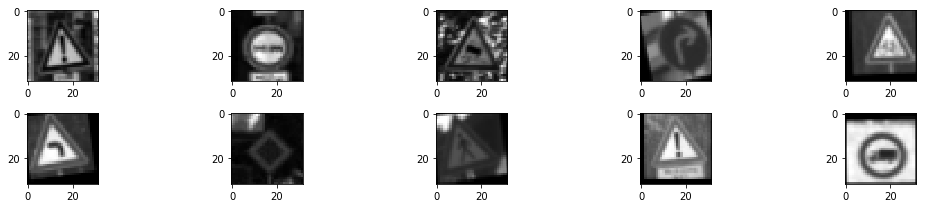

In [36]:
# examples of the preprocessed images
random.seed(19)
list_index_samples = random.sample(range(len(X_train)), 10)
fig=plt.figure(figsize=(15, 3))
columns = 5
rows = 2
for i in range(1,len(list_index_samples)+1):
    ind = list_index_samples[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train_after[ind].squeeze(), cmap ='gray')
fig.tight_layout()
plt.savefig('preprocessed.png')
plt.show()

### Model Architecture

In [37]:
# hyper parameters  
epochs = 40 # number of epoch
batch_size = 32 # batch size
rate = 0.0008 # learning_rate

def traffic_sign_nn(x):    
    # parameters used for tf.truncated_normal for the initialization of the weights and biases
    mu = 0
    sigma = 0.1
    
    # Convolutional Layer 1 
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, n_channel, 8), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(8))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)

    # to be used later
    fc_a = tf.contrib.layers.flatten(conv1)
    
    # Convolutional Layer 2 
    conv2_W = tf.Variable(tf.truncated_normal(shape=(4, 4, 8, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 2, 2, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)

    # to be used later
    fc_b = tf.contrib.layers.flatten(conv2)
    
    # Convolutional Layer 3 
    conv3_W = tf.Variable(tf.truncated_normal(shape=(4, 4, 16, 32), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(32))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b    
    conv3 = tf.nn.relu(conv3)
    
    # to be used later
    fc_c = tf.contrib.layers.flatten(conv3)

    # Convolutional Layer 4 
    conv4_W = tf.Variable(tf.truncated_normal(shape=(4, 4, 32, 64), mean = mu, stddev = sigma))
    conv4_b = tf.Variable(tf.zeros(64))
    conv4   = tf.nn.conv2d(conv3, conv4_W, strides=[1, 2, 2, 1], padding='VALID') + conv4_b   
    conv4 = tf.nn.relu(conv4)
    
    fc0   = tf.contrib.layers.flatten(conv4)
    
    fc_combo = tf.concat(values=[fc0, fc_a, fc_b, fc_c], axis = 1)
    fc_combo_dim = fc_combo.get_shape().as_list()[1]
    
    # Fully Connected Layer 1
    fc1_W = tf.Variable(tf.truncated_normal(shape=(fc_combo_dim, 512), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(512))
    fc1   = tf.matmul(fc_combo, fc1_W) + fc1_b
    fc1    = tf.nn.relu(fc1)

    # Fully Connected Layer 2
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(512, 256), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(256))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.relu(fc2)
    
    # Fully Connected Layer 2
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(256, 128), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(128))
    fc3    = tf.matmul(fc2, fc3_W) + fc3_b
    fc3    = tf.nn.relu(fc3)

    # Fully Connected Layer 3
    fc4_W  = tf.Variable(tf.truncated_normal(shape=(128, n_classes), mean = mu, stddev = sigma))
    fc4_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc3, fc4_W) + fc4_b
    
    return logits, conv1, conv2, conv3, conv4

In [38]:
# tf.placeholder for input and output 
dims_input = X_train_after.shape[1:]

x = tf.placeholder(tf.float32, (None, dims_input[0], dims_input[1], dims_input[2]))
y = tf.placeholder(tf.int32, (None))

# one hot encoding of labels
one_hot_y = tf.one_hot(y, n_classes)

In [39]:
logits, conv1, conv2, conv3, conv4 = traffic_sign_nn(x)

# loss (cross entropy with softmax)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)

# Optimization by Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [40]:
# computing accuracy 
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [41]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_after)
    max_validation_accuracy = 0.0 
    hist_train_accuracy = []
    hist_validation_accuracy = []
    hist_epoch = []
    
    print("Training...")
    print()
    for i in range(epochs):
        # randomize the inputs and labels
        X_train_after, y_train_after = shuffle(X_train_after, y_train_after, random_state = 831)
        
        for offset in range(0, num_examples, batch_size):
            end = offset + batch_size
            batch_x, batch_y = X_train_after[offset:end], y_train_after[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        train_accuracy = evaluate(X_train_after, y_train_after)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(train_accuracy))
            
        validation_accuracy = evaluate(X_valid_after, y_valid_after)
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
        # to be used for ploting history
        hist_epoch.append(i+1)
        hist_train_accuracy.append(train_accuracy)
        hist_validation_accuracy.append(validation_accuracy)
        
        if(validation_accuracy > max_validation_accuracy):
            max_validation_accuracy = validation_accuracy
            saver.save(sess, './traffic_sign_nn')
            print("Model saved")
        
        print()
            
    print("Best Validation Accuracy = {:.3f}".format(max_validation_accuracy))

Training...

EPOCH 1 ...
Training Accuracy = 0.935
Validation Accuracy = 0.891
Model saved

EPOCH 2 ...
Training Accuracy = 0.970
Validation Accuracy = 0.928
Model saved

EPOCH 3 ...
Training Accuracy = 0.974
Validation Accuracy = 0.925

EPOCH 4 ...
Training Accuracy = 0.969
Validation Accuracy = 0.926

EPOCH 5 ...
Training Accuracy = 0.983
Validation Accuracy = 0.924

EPOCH 6 ...
Training Accuracy = 0.993
Validation Accuracy = 0.946
Model saved

EPOCH 7 ...
Training Accuracy = 0.986
Validation Accuracy = 0.950
Model saved

EPOCH 8 ...
Training Accuracy = 0.995
Validation Accuracy = 0.967
Model saved

EPOCH 9 ...
Training Accuracy = 0.991
Validation Accuracy = 0.957

EPOCH 10 ...
Training Accuracy = 0.996
Validation Accuracy = 0.961

EPOCH 11 ...
Training Accuracy = 0.991
Validation Accuracy = 0.959

EPOCH 12 ...
Training Accuracy = 0.990
Validation Accuracy = 0.958

EPOCH 13 ...
Training Accuracy = 0.994
Validation Accuracy = 0.961

EPOCH 14 ...
Training Accuracy = 0.996
Validation Ac

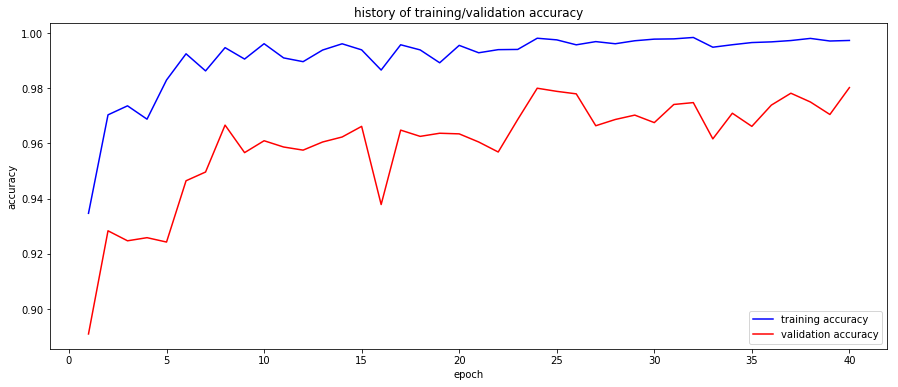

In [42]:
# history of the training and validation accuracy
plt.figure(figsize=(15,6))
plt.plot(hist_epoch, hist_train_accuracy, color = "blue")
plt.plot(hist_epoch, hist_validation_accuracy, color = "red")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("history of training/validation accuracy")
plt.legend(["training accuracy","validation accuracy"])
plt.savefig('history_accuracy.png')
plt.show()

In [43]:
### compute accuracy for the test set 
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_after, y_test_after)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./traffic_sign_nn
Test Accuracy = 0.951


INFO:tensorflow:Restoring parameters from ./traffic_sign_nn


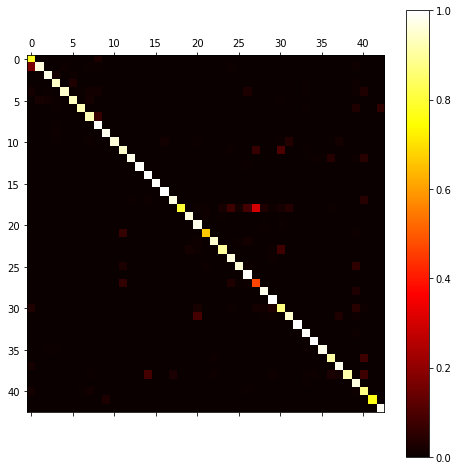

In [44]:
### evaluate the confusion matrix for test set 

# compute prediction for the test set
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    prediction_test = sess.run(tf.argmax(logits, 1), feed_dict = {x: X_test_after})

# confusion matrix for test set 
cm = confusion_matrix(y_test_after, prediction_test)
cm = cm/cm.astype(np.float).sum(axis=1) # normalization
fig=plt.figure(figsize=(8, 8))
plt.matshow(cm, fignum=1, cmap='hot')
plt.colorbar()
plt.savefig('confusion_matrix.png')
plt.show()

In [45]:
### further detail (precision, recall etc.) for the test set can be seen here 
print(classification_report(y_test_after, prediction_test))

             precision    recall  f1-score   support

          0       0.76      0.78      0.77        60
          1       0.97      0.97      0.97       720
          2       0.97      0.97      0.97       750
          3       0.94      0.94      0.94       450
          4       0.98      0.95      0.97       660
          5       0.95      0.94      0.94       630
          6       0.99      0.93      0.96       150
          7       0.93      0.93      0.93       450
          8       0.89      1.00      0.94       450
          9       0.97      0.98      0.98       480
         10       0.99      0.96      0.98       660
         11       0.86      0.95      0.90       420
         12       0.99      0.98      0.98       690
         13       1.00      1.00      1.00       720
         14       0.90      1.00      0.95       270
         15       1.00      1.00      1.00       210
         16       0.99      1.00      0.99       150
         17       0.97      0.97      0.97   

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

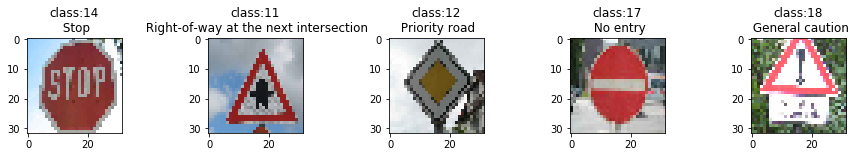

In [46]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

# All the images we will use here are takine from http://bicyclegermany.com/german_bicycle_laws.html. 
# Traffic signs are extracted in the square shape from the original images

# read new images and their labels
path_image_folder = '../traffic_signs_web/'
list_filename = [filename for filename in sorted(os.listdir(path_image_folder)) if filename[-3:] == "jpg"]

path_resized_image_folder = path_image_folder + 'resized'
if not os.path.exists(path_resized_image_folder):
    os.makedirs(path_resized_image_folder)

X_web = []
for filename in list_filename:
    img = Image.open(path_image_folder + filename , 'r')
    resize_img = img.resize((32, 32))
    resize_img.save(path_resized_image_folder +"/resized_" + filename, 'JPEG', quality=100, optimize=True)
    X_web.append(np.array(resize_img))
X_web = np.asarray(X_web)

# labels for new images
y_web = np.array([14, 11, 12, 17, 18])

# plot the new images 
fig=plt.figure(figsize=(12, 3))
columns = len(X_web)
rows = 1
for i in range(1, len(X_web)+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_web[i-1])
    plt.title('class:' + str(y_web[i-1]) + '\n ' + name_dict[y_web[i-1]])
fig.tight_layout()
plt.savefig('new_examples.png')
plt.show()

### Predict the Sign Type for Each Image

In [47]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

# carry out the image preprocessing in the same way as the training, test, validation dataset
X_web_after = X_web.copy()
y_web_after = y_web.copy()

X_web_after = image_preprocessing(X_web_after, grayscale= True)

In [48]:
# prediction for the new images 
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    prediction_web = sess.run(tf.argmax(logits, 1), feed_dict = {x: X_web_after})

print('prediction', prediction_web)
print('actual class', y_web)

INFO:tensorflow:Restoring parameters from ./traffic_sign_nn
prediction [14 11 12 17 22]
actual class [14 11 12 17 18]


### Analyze Performance

In [49]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    web_accuracy = evaluate(X_web_after, y_web_after)
    print("Accuracy for New Images = {:.3f}".format(web_accuracy))

INFO:tensorflow:Restoring parameters from ./traffic_sign_nn
Accuracy for New Images = 0.800


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [50]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

# compute the top five softmax probabilities for the prediction for the five new images 
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    web_top5 = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), feed_dict = {x: X_web_after})

for i in range(X_web_after.shape[0]):
    print("image", i)
    print("top 5 probabilities:")
    print(web_top5.values[i])
    print("classes for top 5 probabilities:")
    print(web_top5.indices[i])
    print()

INFO:tensorflow:Restoring parameters from ./traffic_sign_nn
image 0
top 5 probabilities:
[  1.00000000e+00   2.09687173e-14   6.88496846e-22   8.20793403e-25
   8.93534620e-28]
classes for top 5 probabilities:
[14  0  3 36 13]

image 1
top 5 probabilities:
[ 1.  0.  0.  0.  0.]
classes for top 5 probabilities:
[11  0  1  2  3]

image 2
top 5 probabilities:
[ 1.  0.  0.  0.  0.]
classes for top 5 probabilities:
[12  0  1  2  3]

image 3
top 5 probabilities:
[ 1.  0.  0.  0.  0.]
classes for top 5 probabilities:
[17  0  1  2  3]

image 4
top 5 probabilities:
[  7.60286331e-01   2.39713624e-01   3.72845896e-08   2.61997712e-09
   2.60583439e-12]
classes for top 5 probabilities:
[22 23  9 25  3]



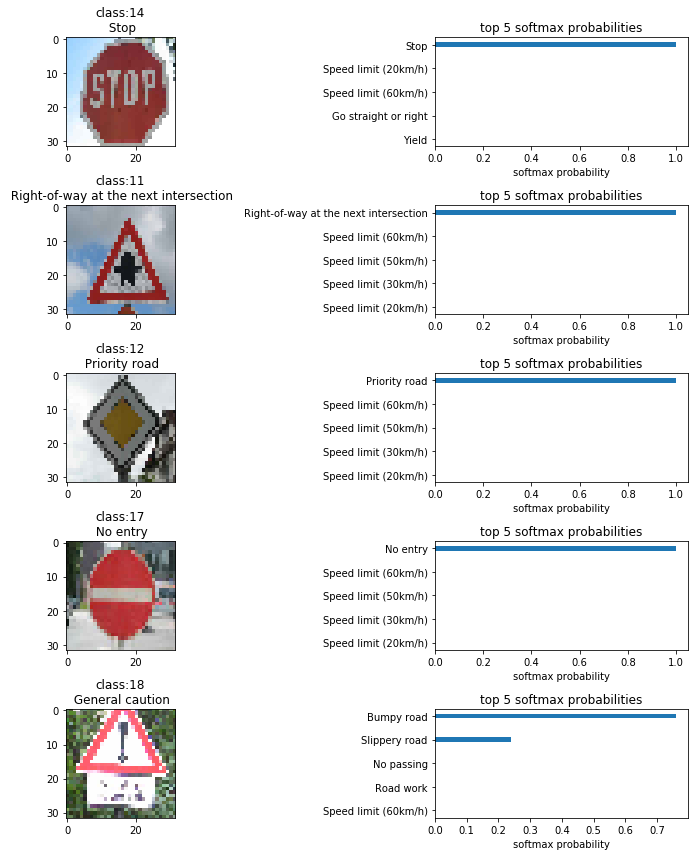

In [51]:
# plot the top 5 probabilities

list_names_top5 = []
for i in range(web_top5.indices.shape[0]):
    list_names = []
    for j in range(web_top5.indices.shape[0]):
        list_names.append(name_dict[web_top5.indices[i][j]])
    list_names_top5.append(list_names)

fig=plt.figure(figsize=(10, 12))
columns = 2 
rows = web_top5.values.shape[1]
w = 1.0
step_aes = 5
for i in range(1, web_top5.values.shape[0]+1):
    
    fig.add_subplot(rows, columns, 2*i-1)
    plt.imshow(X_web[i-1])
    plt.title('class:' + str(y_web[i-1]) + '\n ' + name_dict[y_web[i-1]])
    
    fig.add_subplot(rows, columns, 2*i)
    df = pd.DataFrame()
    df['names'] = list_names_top5[i-1]
    df['prob'] = web_top5.values[i-1]
    df = df.sort_values('prob', ascending = True)
    plt.barh(np.arange(web_top5.values.shape[1]*step_aes,step=step_aes), df['prob'], w, align='center')
    plt.yticks(np.arange(web_top5.values.shape[1]*step_aes,step=step_aes), df['names'])
    plt.title('top 5 softmax probabilities')
    plt.xlabel('softmax probability')
    
fig.tight_layout()
plt.savefig('prediction_new_examples.png')
plt.show()

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [52]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1, 
                                                             plt_num=1, output_file ='visual.png'):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15, int(featuremaps/8)*3))
    for featuremap in range(featuremaps):
        plt.subplot(math.ceil(featuremaps/8),8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()

INFO:tensorflow:Restoring parameters from ./traffic_sign_nn


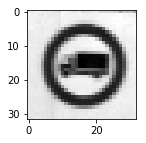

1st convolutional layer


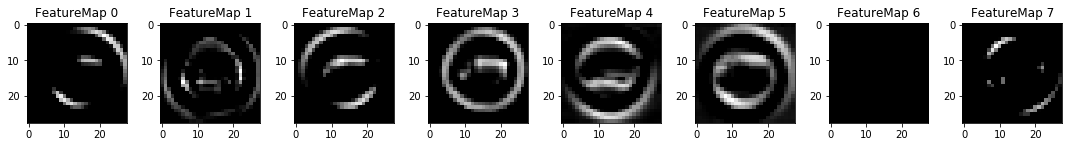

2nd convolutional layer


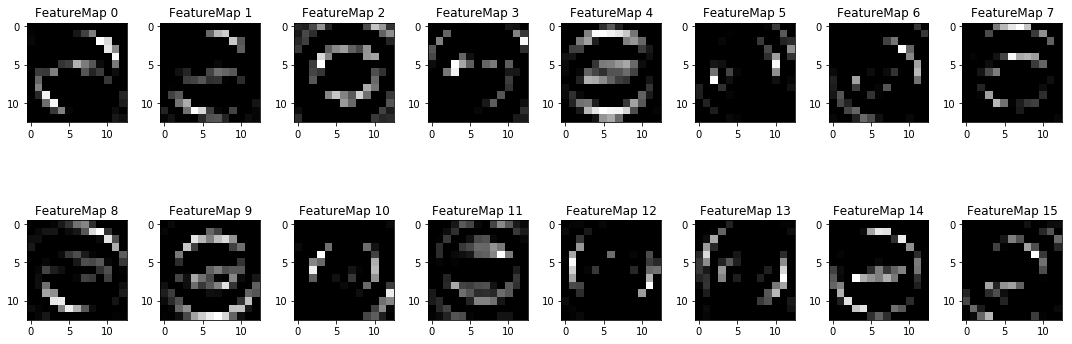

3rd convolutional layer


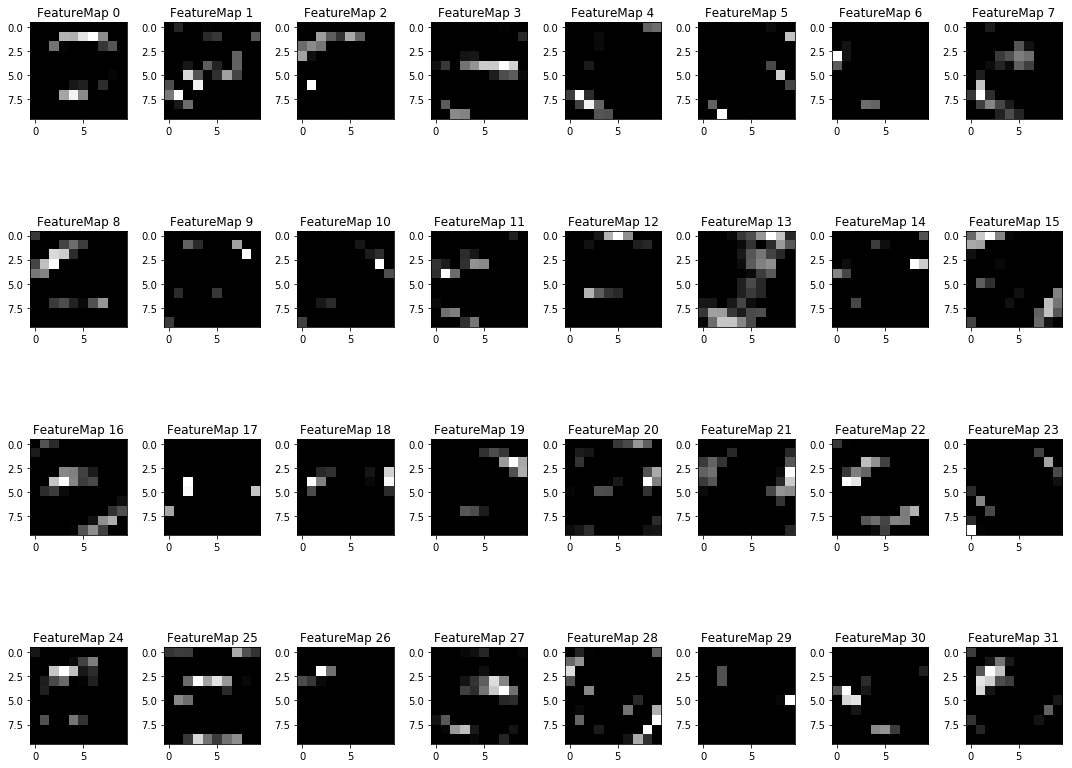

4th convolutional layer


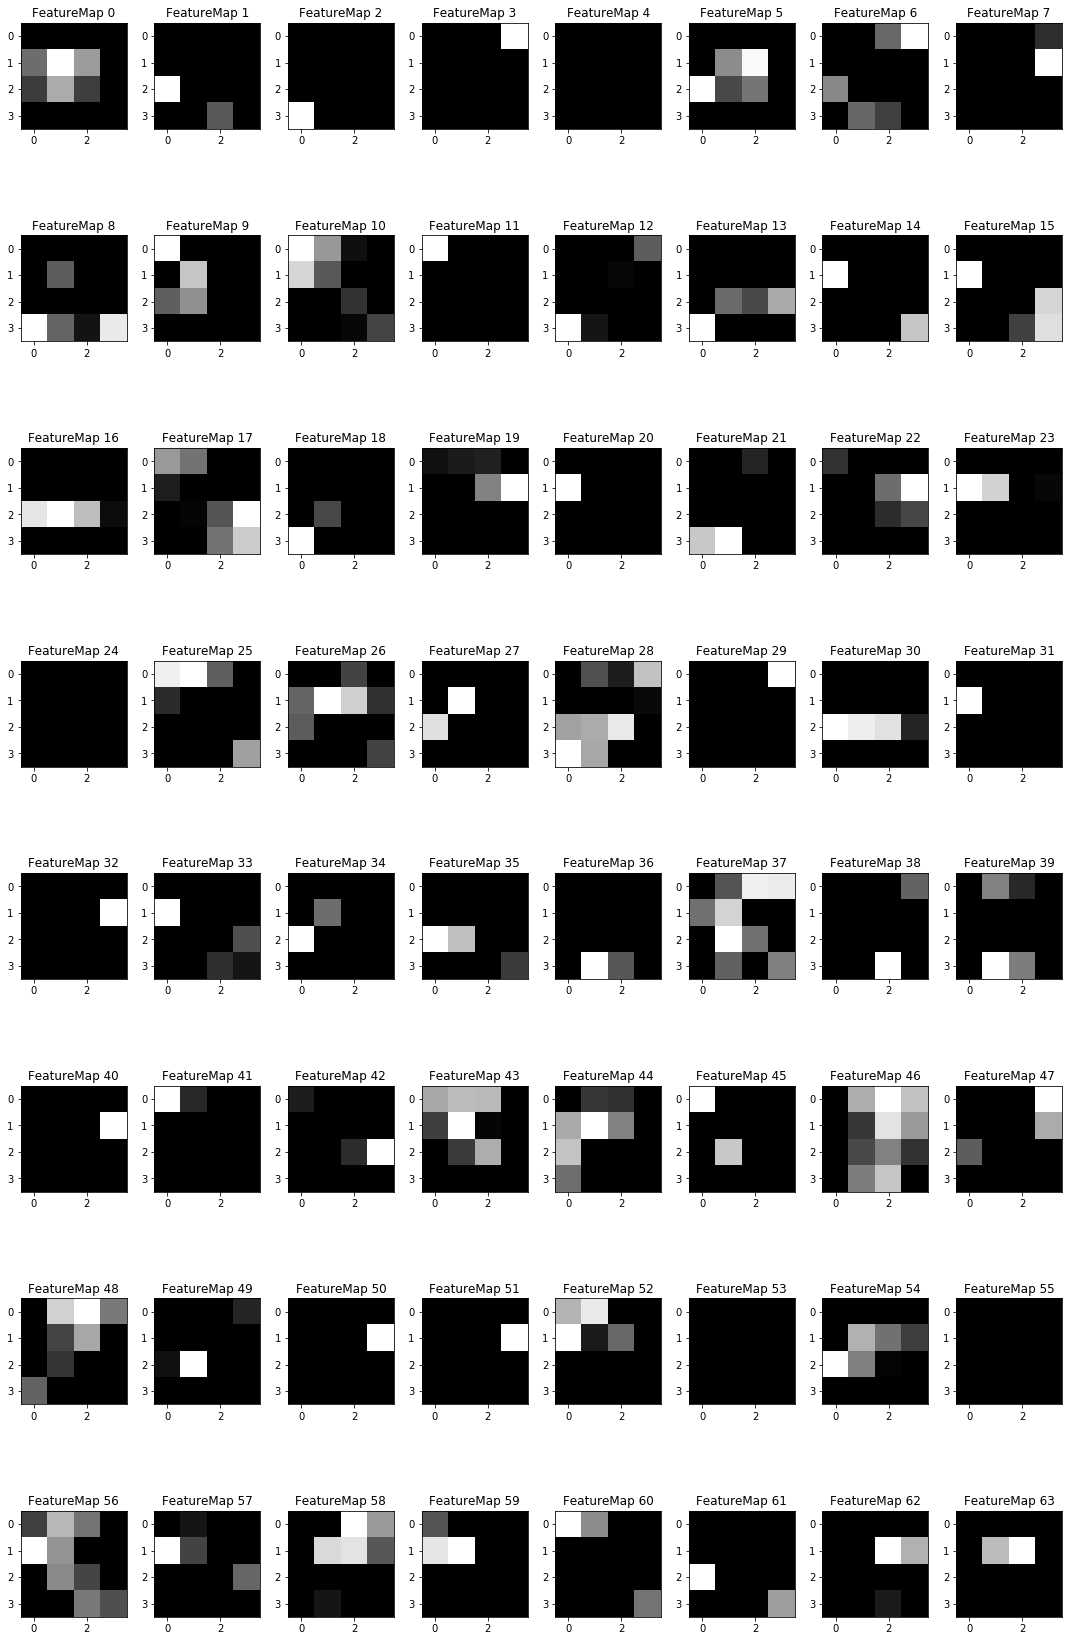

In [53]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    # input image
    image_input = X_test_after[0]
    plt.figure(figsize=(2, 2))
    plt.imshow(image_input.squeeze(), cmap="gray")
    plt.savefig("visual_original.png")
    plt.show()
    
    print("1st convolutional layer")
    outputFeatureMap([image_input], tf_activation = conv1, activation_min=-1, 
                                                     activation_max=-1 ,plt_num=1, output_file = 'visual1.png')
    print("2nd convolutional layer")
    outputFeatureMap([image_input], tf_activation = conv2, activation_min=-1, 
                                                     activation_max=-1 ,plt_num=1, output_file = 'visual2.png')
    print("3rd convolutional layer")
    outputFeatureMap([image_input], tf_activation = conv3, activation_min=-1, 
                                                     activation_max=-1 ,plt_num=1, output_file = 'visual3.png')

    print("4th convolutional layer")
    outputFeatureMap([image_input], tf_activation = conv4, activation_min=-1, 
                                                     activation_max=-1 ,plt_num=1, output_file = 'visual4.png')